# Introduction

Understanding the spatial distribution of archaeological sites and artifacts is a fundamental aspect of studying past human activities. However, a significant challenge arises when considering the temporality and chronological uncertainty associated with these points. Not all points we observe in the archaeological record were necessarily contemporaneous, and our chronometric tools for dating them often have significant uncertainties. This complicates traditional point pattern analyses, which typically assume that all points are fixed in both space and time.

ChronoCluster is a Python package designed to address this challenge. It provides tools for analyzing spatial point patterns with temporality and chronological uncertainty, incorporating methods like Ripley's K function and point-wise distance distributions to account for these factors. By allowing for the integration of temporal distributions and uncertainties into spatial analyses, ChronoCluster helps researchers obtain more accurate and meaningful insights from archaeological (and, for that matter, historical and even palaeoclimatic) point data.

Key features of ChronoCluster include:

- Visualization tools for spatial point patterns, including the ability to represent temporal distributions;
- Clustering analysis using Ripley's K, L, and G functions, accounting for temporality (change over time) and chronological uncertainty;
- Pairwise distance distributions accounting for both temporality and chronological uncertainty; and
- Comparison of observed patterns to CSR (Complete Spatial Randomness) baselines to determine significant clustering or dispersion patterns.

In this workbook, you'll be introduced to the package, its paradigm, its terminology, and its key functions and features.

# Spacetime Archaeology

In spatial analysis, a point represents a location of interest within a given study area. In archaeology, points often represent the locations of sites or artifacts. A point pattern is a collection of such points, which can be analyzed to reveal spatial relationships and patterns, such as clustering or dispersion.

Traditional point pattern analyses assume that all points are fixed in both space and time. However, in archaeology, points have temporality—each site or artifact existed at a specific time, and our ability to date these points often comes with significant uncertainties. This complicates analyses as it requires considering the temporal existence and chronological uncertainty of these points.

## Spacetime Thinking

To better analyze archaeological points, we can adopt a spacetime perspective. In this framework, each point has not only spatial coordinates (x, y) but also a temporal coordinate (z), representing its existence over time. This approach allows us to visualize and analyze the temporal dimension of archaeological data, considering when each point existed and the uncertainties associated with its dating.

## Key Terms and Definitions
| Term            | Definition                                                                                      |
|-----------------|-------------------------------------------------------------------------------------------------|
| **Point**       | A location of interest within a study area, represented by spatial coordinates (x, y).          |
| **Point Pattern** | A collection of points analyzed to reveal spatial relationships and patterns.                    |
| **Temporality** | The characteristic of a point having a specific existence in time.                              |
| **Chronological Uncertainty** | The uncertainty associated with the dating of a point.                                  |
| **Space-Time Volume** | A conceptual model with spatial dimensions (x, y) and a temporal dimension (z).                |
| **Temporal Distribution** | A probability distribution representing the possible times during which a point existed.   |
| **World Line**  | In physics, the path that an object traces in 4-dimensional spacetime. Here, it refers to the temporal existence of a point in the space-time volume. |
| **Palimpsest**  | An archaeological term commonly used to describe the overlap of multiple temporal layers of human activity within the same spatial location. |

## Space-Time Volume

A **space-Time Volume** (STV) refers to a conceptual model where the x and y axes represent spatial dimensions and the z axis represents the temporal dimension. Each archaeological site or artifact can be thought of as existing within this volume, with a certain temporal duration and spatial extent.

## Example: Representing a Single Archaeological Site in Space-Time

Let's consider an example where we have an archaeological site represented as a single point. This site has a known spatial location but uncertain temporal existence. We can model its temporal presence using probability distributions.

In a plot below, we'll illustrate:

- The spatial location of the site on the x-y plane.
- The temporal presence of the site as a vertical pipe in the space-time volume, where the z-axis represents time.
- A **time slice** indicating a specific moment in time, showing the likelihood of the site's presence during that period.

We will need a number of libraries:

In [1]:
# Analysis
import numpy as np
from chronocluster.data.simdata import generate_random_points
from chronocluster import clustering
from chronocluster.utils import clustering_heatmap, pdiff_heatmap, plot_mc_points, get_box, ddelta, chrono_plot
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

Then, we need to generate a random point using some ChronoCluster functions and probability distributions (those will be explained further down) just to illustrate some key ideas:

In [2]:
# define cluster distributions
cluster_center = (10, 10)
cluster_std = 1.0

# randomly select point coords
x_coord = np.random.normal(loc=cluster_center[0], scale=cluster_std, size=1)[0]
y_coord = np.random.normal(loc=cluster_center[1], scale=cluster_std, size=1)[0]

start_age_mean = 1000
start_age_err = 50
end_age_mean = 1200
end_age_err = 50

# create random start and end ages with uncertainty
start_dist = norm(loc=start_age_mean, scale=start_age_err)
end_dist = norm(loc=end_age_mean, scale=end_age_err)

# finally, generate random point
points = [clustering.Point(x = x_coord, 
              y = y_coord, 
              start_distribution = start_dist, 
              end_distribution = end_dist)]

And, lastly, we can call a ChronoCluster plotting function to plot the point in a spacetime volume:

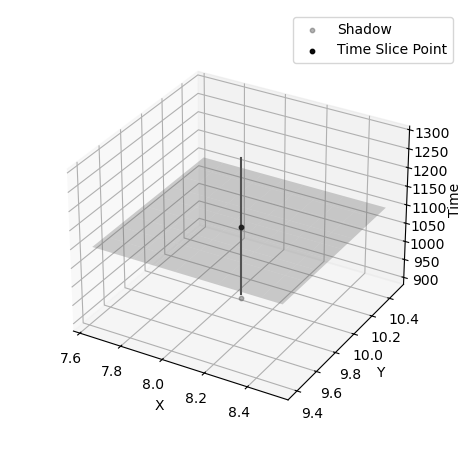

In [3]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=1100)
ax.set_box_aspect(None, zoom=0.85)

## Interpreting the Plot

In this example, we generated a single point with spatial coordinates and temporal distributions for its start and end dates. The plot visualizes the point's spatial location, its temporal presence, and its likelihood of being present at a specified time slice. This visual representation helps to introduce the concept of analyzing archaeological point patterns with both temporality and chronological uncertainty.

- Spatial Location: The x and y coordinates represent the geographical location of the archaeological site.
- Temporal Presence: The vertical gray pipe represents the temporal presence of the site within the space-time volume. This is determined by the probability distributions for the start and end dates.
- Time Slice: The grey, semi-transparent plane represents a specific time slice (in this case, at 1100 years). If a point's world line intersects the plane, the intersection is represented by a black dot (time slice point) on the plane, indicating that the point is 'present' in the pattern at that time.

## Understanding the Pipe and PPF

The pipe illustrates the site's temporal persistence within the space-time volume. The ends of the pipe are determined by the start and end distributions' percent point functions (PPF). The PPF, also known as the inverse cumulative distribution function (CDF), defines the specific points in time at which the cumulative probability reaches a certain value. For instance, a PPF value at the 1st percentile (PPF(0.01)) and the 99th percentile (PPF(0.99)) gives us a range within which we are 98% confident the event occurred.

To make this clearer, let's visualize the start and end distributions of a single point and the resulting world line in a 2D plot focused only on time and not space. The horizontal axis will represent the time duration during which the point exists in the space-time volume.

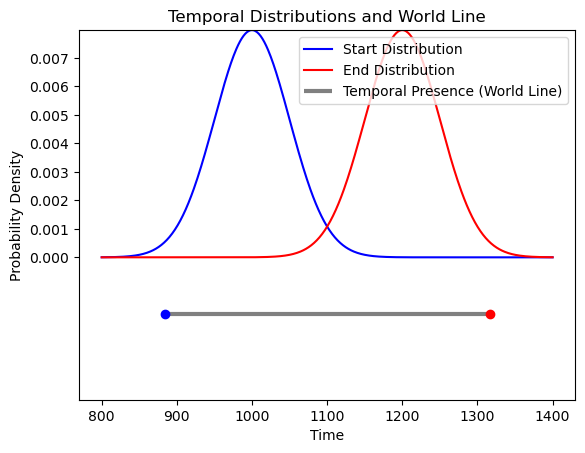

In [4]:
# Define the start and end distributions
start_age_mean = 1000
start_age_err = 50
end_age_mean = 1200
end_age_err = 50

start_dist = norm(loc=start_age_mean, scale=start_age_err)
end_dist = norm(loc=end_age_mean, scale=end_age_err)

# Generate a range of x values (time)
x = np.linspace(800, 1400, 500)

# Plot the probability density functions (PDFs)
plt.plot(x, start_dist.pdf(x), label='Start Distribution', color='blue')
plt.plot(x, end_dist.pdf(x), label='End Distribution', color='red')

# Determine the PPF limits (1st and 99th percentiles)
start_ppf = (start_dist.ppf(0.01), start_dist.ppf(0.99))
end_ppf = (end_dist.ppf(0.01), end_dist.ppf(0.99))

# Plot horizontal line (world line) between start and end PPFs
world_line_y = -0.002
plt.hlines(world_line_y, start_ppf[0], end_ppf[1], color='gray', linewidth=3, label='Temporal Presence (World Line)')

# Annotate the PPF limits
plt.scatter([start_ppf[0]], [world_line_y], color='blue', zorder=5)
plt.scatter([end_ppf[1]], [world_line_y], color='red', zorder=5)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.title('Temporal Distributions and World Line')
plt.ylim(-0.005, max(start_dist.pdf(x).max(), end_dist.pdf(x).max()))

# Set y-axis limits and ticks to avoid negative values
max_density = max(start_dist.pdf(x).max(), end_dist.pdf(x).max())
plt.ylim(-0.005, max_density)
plt.yticks( np.arange(0.000, max_density, 0.001) )

plt.show()

### Explanation of the Plot

In the plot:

- The blue curve represents the start distribution, showing the probability of the site's presence starting at different times.
- The red curve represents the end distribution, showing the probability of the site's presence ending at different times.
- The gray horizontal line near the x-axis represents the world line, indicating the temporal persistence of the site within the space-time volume.
- The blue dot marks the 1st percentiles of the start distribution.
- The red dot marks the 99th percentiles of the end distribution.

This plot helps visualize how the temporal distributions of a point define its temporal presence and how we can model the uncertainties associated with dating the point. The pipe in the 3D plot from before extends vertically between the PPF limits of the start and end distributions, representing the point's presence over time.

The chrono_plot function makes use of these concepts to visualize the temporal persistence of points in the space-time volume. The function takes the spatial coordinates (x, y) and the temporal distributions (start and end) of points and generates a 3D plot with:

- Pipes representing the temporal presence of each point.
- Time slice planes to visualize the presence of points at specific moments in time.

## Representing Spacetime Points in ChronoCluster

With these visualizations and spacetime concepts in mind, we can look at how ChronoCluster represents points in spacetime internally. The package uses a **Point** class. This class encapsulates both the spatial coordinates and the temporal distributions that describe when the point exists. Below, we will explain the Point class, its attributes, and key methods such as calculating inclusion probabilities for time slices.

### The Point Class

The Point class is designed to hold information about a single point in spacetime, including its spatial location and the temporal distributions that define its presence over time.

Attributes:

- x (float): The x-coordinate of the point.
- y (float): The y-coordinate of the point.
- start_distribution (scipy.stats.rv_continuous): The probability distribution for the start date.
- end_distribution (scipy.stats.rv_continuous): The probability distribution for the end date.

Key Methods:

1. Initialization (```__init__``` method):

The constructor initializes a new Point instance with given coordinates and distributions.

```python
def __init__(self, x, y, start_distribution, end_distribution, verbose=False):
    self.x = x
    self.y = y
    self.start_distribution = start_distribution
    self.end_distribution = end_distribution
    if verbose:
        print("Temporal consistency check...")
    self._check_distributions(verbose)
```

2. Checking Distributions (```_check_distributions``` method):

This private method checks the temporal consistency of the start and end distributions.

```python
def _check_distributions(self, verbose):
    overlap_ratio = self._calculate_overlap_ratio()
    if overlap_ratio > 0.25:
        print(f"Warning: Significant overlap between start and end distributions. Overlap ratio: {overlap_ratio:.2f}")
    start_mean = self.start_distribution.mean()
    end_mean = self.end_distribution.mean()
    if end_mean < start_mean:
        print(f"Warning: End date distribution mean ({end_mean}) is earlier than start date distribution mean ({start_mean}). Possible data error.")

```
3. Calculating Overlap Ratio (```_calculate_overlap_ratio``` method):

This private method calculates the overlap ratio between the start and end distributions.

```python
def _calculate_overlap_ratio(self):
    range_min = min(self.start_distribution.ppf(0.01), self.end_distribution.ppf(0.01))
    range_max = max(self.start_distribution.ppf(0.99), self.end_distribution.ppf(0.99))
    x = np.linspace(range_min, range_max, 1000)
    start_pdf = self.start_distribution.pdf(x)
    end_pdf = self.end_distribution.pdf(x)
    overlap_pdf = np.minimum(start_pdf, end_pdf)
    overlap_area = np.trapz(overlap_pdf, x)
    total_area_start = np.trapz(start_pdf, x)
    total_area_end = np.trapz(end_pdf, x)
    combined_area = total_area_start + total_area_end
    if combined_area == 0:
        print(f"Warning: Sum of density integrals is zero! Check that start and end dates are present and, if constant, not identical.")
        overlap_ratio = np.nan
    else:
        overlap_ratio = overlap_area / combined_area
    return overlap_ratio
```

4. Calculating Inclusion Probability (```calculate_inclusion_probability``` method):

This method calculates the inclusion probability of the point for a given time slice.

```python
def calculate_inclusion_probability(self, time_slice):
    start_prob = self.start_distribution.cdf(time_slice)
    if start_prob <= 0:  # If start probability is zero or negative
        return 0.0
    end_prob = self.end_distribution.sf(time_slice)
    return start_prob * end_prob
```

### Calculating Inclusion Probabilities

The last of these highlighted methods is a key concept in ChronoCluster. Inclusion probability -- the likelihood that a point is present in the pattern at a specific time slice -- is used throughout the package for analyses and plotting. The inclusion probability for a given point is calculated using the cumulative distribution function (CDF) of the start distribution and the survival function (SF) of the end distribution for that point.

- Cumulative Distribution Function (CDF): The CDF of a distribution gives the probability that a random variable is less than or equal to a certain value. For a given time slice $t$, the CDF of the start distribution $F_{start}(t)$ represents the probability that the point's existence has started by that time.

- Survival Function (SF): The survival function, also known as the complementary cumulative distribution function, gives the probability that a random variable is greater than a certain value. For a given time slice $t$, the SF of the end distribution $S_{end}(t)$ represents the probability that the point's existence has not ended by that time.

The inclusion probability, $ P_{\text{inclusion}} $, at a time slice, $ t $, is given by:

$$
P_{\text{inclusion}}(t) = F_{\text{start}}(t) \times S_{\text{end}}(t)
$$

Where:

- $ F_{\text{start}}(t) $ is the CDF of the start distribution at time $ t $
- $ S_{\text{end}}(t) $ is the SF of the end distribution at time $ t $


### Custom ddelta Probability Class in ChronoCluster

ChronoCluster allows for flexibility in representing the temporal distributions of points. A point can have different start and end distributions, which can belong to different families of probability distributions. This flexibility is essential for modeling various types of temporal uncertainties and certainties in archaeological data.

One of the custom probability distribution classes used in ChronoCluster is the `ddelta` class. This class represents a Dirac delta distribution, which is useful for encoding historical information where we have no uncertainty about the start or end times of a point. The ddirac class inherits from scipy.stats.rv_continuous and approximates the Dirac delta function. This distribution is characterized by a single value dd---representing a fixed time---and it is used when we are certain about the start or end time of a point, as we might be with historical records of site founding or abandonment times, for example.

Here is the implementation of the ddirac class in ChronoCluster:

```python
class ddelta(rv_continuous):
    """Probability functions approximating the Dirac Delta"""
    
    def __init__(self, d):
        super().__init__(name='ddelta')
        self.d = d
        self.dist = self
        self.badvalue = np.nan
        self.a = d
        self.b = d
        self.xtol = 1e-14
        self.moment_type = 1
        self.shapes = None
        self.numargs = 0
        self.vecentropy = np.vectorize(self._entropy)
        self.generic_moment = np.vectorize(self._moment)

    def _pdf(self, x):
        """Probability density function"""
        return np.inf if x == self.d else 0

    def _cdf(self, x):
        """Cumulative distribution function"""
        return 1.0 if x >= self.d else 0.0
    
    def _sf(self, x):
        """Survival function"""
        return 1.0 - self._cdf(x)

    def _ppf(self, q):
        """Percent point function (inverse of cdf)"""
        return self.d

    def _rvs(self, size=None, random_state=None):
        """Random variates"""
        return np.full(size, self.d)

    def mean(self):
        """Mean of the distribution"""
        return self.d
    
    def var(self):
        """Variance of the distribution"""
        return 0.0

    def std(self):
        """Standard deviation of the distribution"""
        return 0.0

    def _entropy(self, *args, **kwargs):
        """Entropy of the distribution"""
        return 0.0

    def _moment(self, n, *args, **kwargs):
        """nth moment of the distribution"""
        if n == 1:
            return self.mean()
        elif n == 2:
            return self.var()**2
        else:
            return np.nan
```

#### Explanation of the ddelta Class

The `ddelta` class represents a distribution where all the probability mass is concentrated at a single point, `d`. This is useful for encoding certainty about the timing of an event.

- Probability Density Function (PDF): The _pdf method returns infinity at $d$ and zero elsewhere, approximating the Dirac delta function.
- Cumulative Distribution Function (CDF): The _cdf method returns 1 for any value greater than or equal to $d$ and $0$ otherwise.
- Survival Function (SF): The _sf method is the complement of the CDF, returning 1 minus the CDF.
- Percent Point Function (PPF): The _ppf method returns dd, indicating the exact point at which the probability mass is concentrated.
- Random Variates (RVS): The _rvs method generates random variates, which are always $d$.
- Mean and Variance: The mean method returns $d$, and the var method returns 0, indicating no variability.

For more information on the Dirac Delta function, you can refer to the following resources:

[Wikipedia: Dirac Delta Function](https://en.wikipedia.org/wiki/Dirac_delta_function)

[Wolfram MathWorld: Dirac Delta Function](https://reference.wolfram.com/language/ref/DiracDelta.html)

### Using the Point Class with different start/end distributions

The ChronoCluster Point class (and relevant analyses) are intended to be flexible enough to account for points that have different start and end date/time distributions, as noted earlier. You can specify different distributions when you create a `Point` object by passing distribution objects that inherit from `scipy.stats.rv_continuous` (constinuous distribution objects). At the moment, though, Chronocluster's data i/o functions (`chronocluster.data` module) only supports Gaussian (`norm`), Uniform (`unif`) constant (`ddelta`) distributions. But, other functions and the `Point` class can take any valid distribution that has `.pdf`, `.cdf`, `._sf`, `.ppf`, and `.rvs` methods that return mathematically correct values. 

In the following example, we will create a `Point` object with:
- A normal distribution for the start time, representing some uncertainty.
- A `ddelta` distribution for the end time, indicating that the end time is known exactly.

In [5]:
point = clustering.Point(x = 10, 
                         y = 10, 
                         start_distribution = norm(loc=1000, scale=50),
                         end_distribution = ddelta(d=1200))

# Display the point's attributes
print(f"Point Coordinates: ({point.x}, {point.y})")
print(f"Start Distribution: Mean = {point.start_distribution.mean()}, Std = {point.start_distribution.std()}")
print(f"End Distribution: Mean = {point.end_distribution.mean()}, Std = {point.end_distribution.std()}")

# And show the tidy in-line printing method for the Point class
print(point)

Point Coordinates: (10, 10)
Start Distribution: Mean = 1000.0, Std = 50.0
End Distribution: Mean = 1200, Std = 0.0
Point(x=10, y=10, start_distribution=norm(loc=1000.0, scale=50.0), end_distribution=ddelta(d=1200))


## Multiple Points in ChronoCluster

To illustrate the capabilities of ChronoCluster in handling multiple points with varying temporal distributions, we can generate a set of random points. Each point will have its own start and end distributions, representing different durations of presence in the STV.

We will use the generate_random_points function to create these points. This function allows us to define cluster distributions, start and end date models, and uncertainties, and then generate a specified number of points based on these parameters.
The generate_random_points Function

The generate_random_points function generates random points based on specified spatial and temporal distributions. Here's a brief overview of its parameters:

- num_points (int): The number of points to generate.
- cluster_centers (list of tuples): The centers of the clusters around which points are generated.
- cluster_stds (list of floats): The standard deviations of the clusters.
- start_type (str): The type of distribution for the start dates (e.g., 'norm' for normal distribution).
- start_hyperparams (list): The hyperparameters for the start date distribution.
- end_type (str): The type of distribution for the end dates (e.g., 'constant' for a fixed end date).
- end_hyperparams (list): The hyperparameters for the end date distribution.

Using this function, we can generate points that are clustered in space and have varying degrees of temporal uncertainty.

### Example: Generating and Plotting Random Points

In the following example, we generate 40 random points divided into two clusters. The points have different start and end date distributions, demonstrating the flexibility of ChronoCluster.

Code Pipeline:

1. Define Cluster Distributions: We specify the centers and standard deviations for two clusters.
2. Create Start and End Age Distributions: We define different models and uncertainties for the start and end dates.
3. Generate Random Points: We use the generate_random_points function to create 40 points, with 20 points in each temporal distribution scenario.
4. Custom Styling: We define custom styling parameters for the plot.
5. Plot the Points: We use the chrono_plot function to visualize the points in the space-time volume.

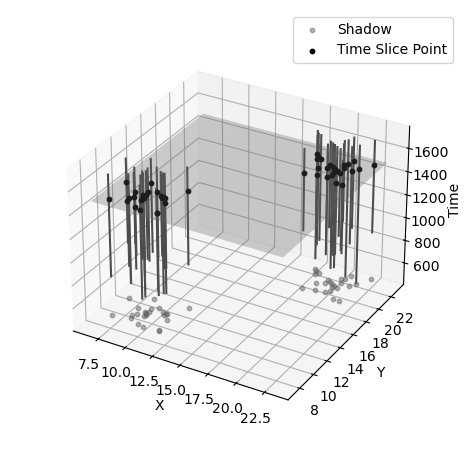

In [6]:
# define cluster distributions
cluster_centers = [(10, 10), (20, 20)]
cluster_stds = [1.0, 1.0]

# create random start and end ages with uncertainty for each point
# define dating models and uncertainties
start_type = 'norm'
start_hyperparams = [1000, 50, 100]
end_type = 'constant'
end_hyperparams = [1700]

# finally, generate 100 random points using the above models
points = generate_random_points(50, 
                                cluster_centers, 
                                cluster_stds, 
                                start_type, 
                                start_hyperparams, 
                                end_type, 
                                end_hyperparams)

# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(points, style_params=style_params, time_slice=1500)
ax.set_box_aspect(None, zoom=0.85)

### Explanation of the Plot

The plot generated by the above code illustrates several key points:

1. Different Points Have Different Presence/Duration in the STV: Each point's **temporal presence** is represented by a vertical cylinder (pipe), the **world line** that extends between its start and end dates. Some points have longer durations (pipes) than others.

2. **World Lines** and **Time Slice** Intersections: Some points have world lines (pipes) that do not intersect the given time slice at 1500 years. These points are not present in the pattern at that specific time, which is visualized by the absence of black dots on the time slice plane at their locations.

3. **Palimpsest** Representation: When we ignore the time dimension, we are looking at the palimpsest— the overlapping of all points in the spatial domain. This is represented in the plot by the shadows of the points on the 'floor' of the plot, showing the aggregated spatial distribution without considering the temporal dimension.

## Pairwise Distances and Clustering Statistics in ChronoCluster

In spatial analysis, pairwise distances are a fundamental measure used to explore clustering structures. By calculating the distances between each pair of points, we can understand how closely points are grouped together. However, temporality and chronological uncertainty complicate these calculations because points may not be contemporaneous and their exact positions in time are uncertain.

### Temporality and Chronological Uncertainty

Temporality refers to the fact that each point exists in space and time, not just space. Chronological uncertainty refers to the inaccuracies in dating these points. Traditional clustering statistics do not account for these complexities, leading to potentially misleading results.
Approach in ChronoCluster

ChronoCluster addresses these issues by:

- Propagating Uncertainty and Temporality: Using Monte Carlo (MC) simulations to propagate chronological uncertainty.
- Applying Spacetime Thinking: Analyzing points in both spatial and temporal dimensions.
- Using Time Slices: Breaking the analysis into discrete time slices to handle temporality.

Key Functions:

- in_probs Function: Precomputes inclusion probabilities based on age models and time slices.
- mc_samples Function: Runs Monte Carlo simulations to generate probable lists of points included in each time slice.
- temporal_pairwise Function: Produces pairwise distances to explore clustering structures over time.
- clustering_heatmap Function: Visualizes temporality and propagates chronological uncertainty into a clustering plot.

### Example: Pairwise Distances with Temporal and Chronological Uncertainty

The following example demonstrates how to compute and visualize pairwise distances with temporal and chronological uncertainty.

#### Step 1: Define Time Slices

In [7]:
# Define the time slices
start_time = 1000
end_time = 2000
time_interval = 50
time_slices = np.arange(start_time, end_time, time_interval)


#### Step 2: Precompute Inclusion Probabilities

In [8]:
# Precompute inclusion probabilities based on age models and time slices
inclusion_probs = clustering.in_probs(points, time_slices)


#### Step 3: Run Monte Carlo Simulations

In [9]:
# Run the Monte Carlo simulation to get an ensemble of probable 
# lists of points included in each time slice.
num_iterations = 100
simulations = clustering.mc_samples(points, 
                                    time_slices, 
                                    inclusion_probs, 
                                    num_iterations=num_iterations)


#### Step 4: Determine Maximum Distance

In [10]:
# Get a bounding box for use later and to extract sensible distance limits
x_min, y_min, x_max, y_max = get_box(points)
max_distance = np.ceil(np.sqrt((x_max - x_min)**2 + (y_max - y_min)**2))


#### Step 5: Produce Pairwise Distances

In [11]:
# Produce pairwise distances to explore clustering structure
pairwise_density, support = clustering.temporal_pairwise(simulations, 
                                                         time_slices, 
                                                         bw=1, 
                                                         density=False, 
                                                         max_distance=max_distance)


#### Step 6: Visualize Clustering
We can visualize the clustering in a couple of ways. First with a heat map and then by randomly sleecting a time slice for plotting.

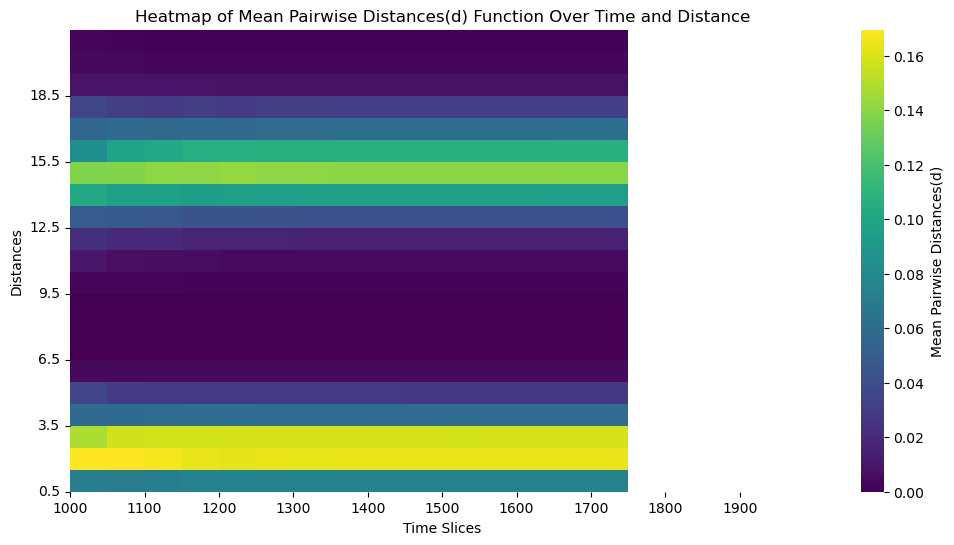

In [12]:
# Visualize clustering with heatmap
clustering_heatmap(pairwise_density,
                   support,
                   time_slices,
                   result_type='Pairwise Distances')


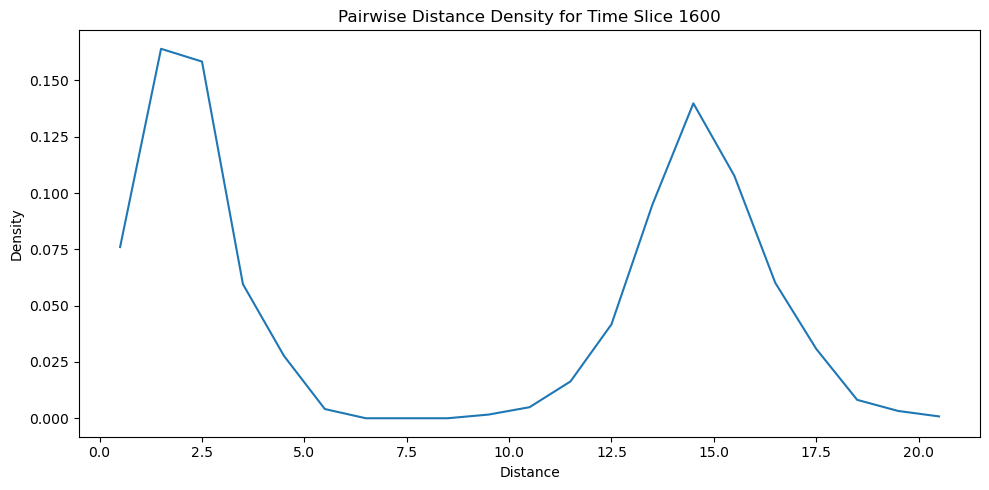

In [13]:
# Plot to see results for a random time slice
rnd_t = int(np.random.uniform(low = 0, high = len(time_slices)))

# Create a line plot
fig, axs = plt.subplots(figsize=(10, 5))

# Plot K results
axs.plot(support, np.mean(pairwise_density[:, rnd_t, :], axis=1))
axs.set_xlabel('Distance')
axs.set_ylabel('Density')
axs.set_title(f'Pairwise Distance Density for Time Slice {time_slices[rnd_t]}')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Interpreting the Clustering Heatmap

The heatmap generated by the `clustering_heatmap` function provides a visual representation of the temporal clustering structure of the points. Here’s an expanded explanation based on the observed heatmap:

**Axes and Color Scale**

- X-Axis (Time Slices): The x-axis represents discrete time slices from 1000 to 2000 years, showing the temporal dimension of the analysis.
- Y-Axis (Distances): The y-axis represents distances between points in the spatial plane (x, y coordinates).
- Color Scale: The color scale represents the mean pairwise distances. The color gradient from purple (low density) to yellow (high density) indicates the relative density of pairwise distances for each time slice.

**Observations**

1. Persistent Clustering Over Time:
    - The heatmap shows persistent clustering through time, indicated by the consistent bands of color. This means that there is a stable structure of clusters in the data across the analyzed time period.

2. Peaks in Pairwise Distances:
    - There are notable peaks in pairwise distances at around 2 and 14 spatial units. These peaks correspond to the smaller clusters and the distance between clusters, respectively.
    - The distance of 2 units represents the average distance between points within the same cluster.
    - The distance of 14 units represents the distance between points in different clusters.

3. Chronological Uncertainty Propagation:
    - The use of Monte Carlo simulations propagates the chronological uncertainty through the time slices. This is reflected in the smooth transitions and variations in color intensity over time.
    - The heatmap marginalizes the propagated chronological uncertainty, averaging the pairwise distances over multiple simulations. But it's important to note that the map represents only one density estimate---in this case the average across MC simulations---which is marginalizing out the uncertainty and is necessary for vizualization. In reality, there is a whole distribution of these surfaces that reflects the chronological uncertainty and samples of that distribution are contained in the `pairwise_density` array.

4. Clusters and Time Slices:
    - In general with this approach, the presence of distinct clusters could be observed across different time slices. Some clusters might not be present in all time slices due to the temporal uncertainty of the points and their temporality. In the simple example above, there is no meaningful temporality, just chronological uncertainty.
    - Points with worldlines that do not intersect a given time slice would not be present in the pattern at that specific time, which would be seen by the absence of corresponding high-density areas in the heatmap for those time slices in cases where the uncertainty was significant and/or there was also temporality in the point pattern.

### Statistical Significance and Complete Spatial Randomness
In spatial analysis, evaluating the statistical significance of observed point patterns against a null hypothesis of Complete Spatial Randomness (CSR) is crucial. CSR assumes that points are distributed uniformly and independently across the study area. By comparing the observed point patterns to this null model, we can determine whether the observed clustering or dispersion is statistically significant in the sense that the patterns would be highly unlikely to occurr if the points were randomly distributed.

ChronoCluster provides functions to perform this comparison and evaluate the statistical significance of point patterns with temporal and chronological uncertainty.

### Example: Evaluating Statistical Significance Against CSR

The following example demonstrates how to calculate the p-values for density differences between observed points and a simulated CSR baseline, and then visualize these p-values using a heatmap. The basic analytical pipeline will involve generating a random point scatter that has the same temporal characteristics of the real (in our case, of course, simulated) data. To do this, ChronoCluster has a function called `csr_sample` that takes a list of `Point` instances and generates a new list with coordinate values randomized in a way that reflects the CSR assumption. Of course, a 'study area' has to be defined and passed in as coordinate limits as well.

#### Step 1: Create CSR Data
We need to create a list of MC simulations as before, but this time with the CSR data. So, we follow the same procedure as above, but replace the `points` list (original data) with a csr sample.

In [14]:
# Generate CSR sample
csr_points = clustering.csr_sample(points, x_min, x_max, y_min, y_max)

# Get CSR inclusion probabilities (remember these points have the same
# temporal traits as the first simulated data)
csr_inclusion_probs = clustering.in_probs(csr_points, 
                                          time_slices)

# Get MC iterations for incorporating chronological uncertainty
num_iterations = 100
csr_simulations = clustering.mc_samples(csr_points, 
                                        time_slices, 
                                        csr_inclusion_probs, 
                                        num_iterations = num_iterations)

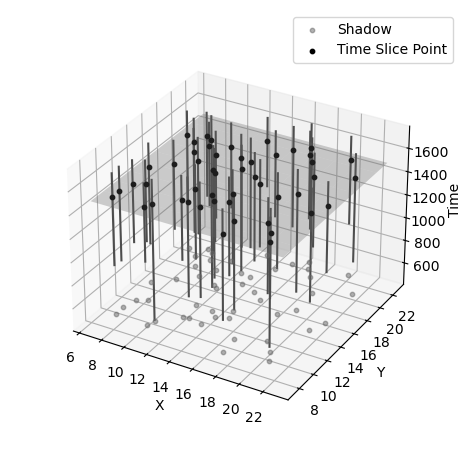

In [15]:
# Custom styling parameters
style_params = {
    'start_mean_color': None,  # Do not plot start mean points
    'end_mean_color': None, # Do not plot end mean points
    'mean_point_size': 10,
    'cylinder_color': (0.3, 0.3, 0.3),  # Dark grey
    'ppf_limits': (0.05, 0.95),  # Use different ppf limits
    'shadow_color': (0.4, 0.4, 0.4),  # grey
    'shadow_size': 10,
    'time_slice_color': (0.5, 0.5, 0.5),  # Grey
    'time_slice_alpha': 0.3,
    'time_slice_point_color': (0, 0, 0),  # Black
}

# Plot the points using the chrono_plot function with custom styling and a time slice plane
ax = chrono_plot(csr_points, style_params=style_params, time_slice=1500)
ax.set_box_aspect(None, zoom=0.85)

#### Step 2. Calculate Pairwise Distance Density for CSR data

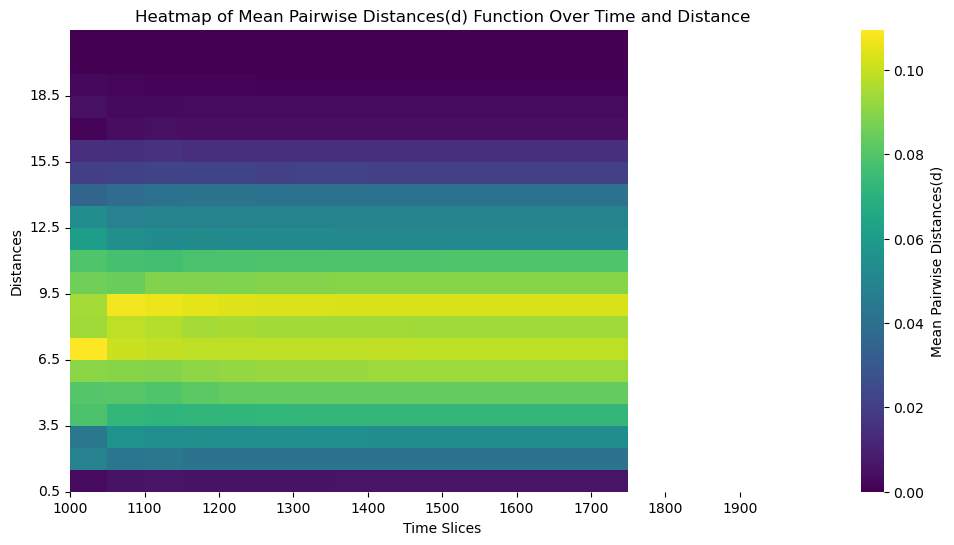

In [19]:
# Calulate the pairwise distances for the CSR sample
csr_pairwise_density, csr_support = clustering.temporal_pairwise(csr_simulations, 
                                                                 time_slices, 
                                                                 bw = 1, 
                                                                 density = False, 
                                                                 max_distance = max_distance)

# Visualize clustering with heatmap
clustering_heatmap(csr_pairwise_density,
                   csr_support,
                   time_slices,
                   result_type='Pairwise Distances')

#### Step 3: Calculate P-Values for Density Differences

We use the p_diff function to calculate the p-values for density differences between the observed points and the simulated CSR baseline for each distance and time slice. Importantly, the distribution we are using for inference is for another random variable, $p_{diff} = P(observed - csr)$ that reflects the chronological uncertainty in the original data.

In [17]:
# Calculate the p-values for density differences between the observed points and 
# the simulated CSR baseline per distance and temporal slice
p_diff_array = clustering.p_diff(pairwise_density, csr_pairwise_density)

#### Step 4: Plot the Heatmap of P-Values

The `pdiff_heatmap` function is used to visualize the p-values, highlighting the statistical significance of the observed clustering patterns. The interpretation depends on the underlying stastic, which at the moment can be either one of the Ripley functions (K, L, or G) or the pairwise distance density.

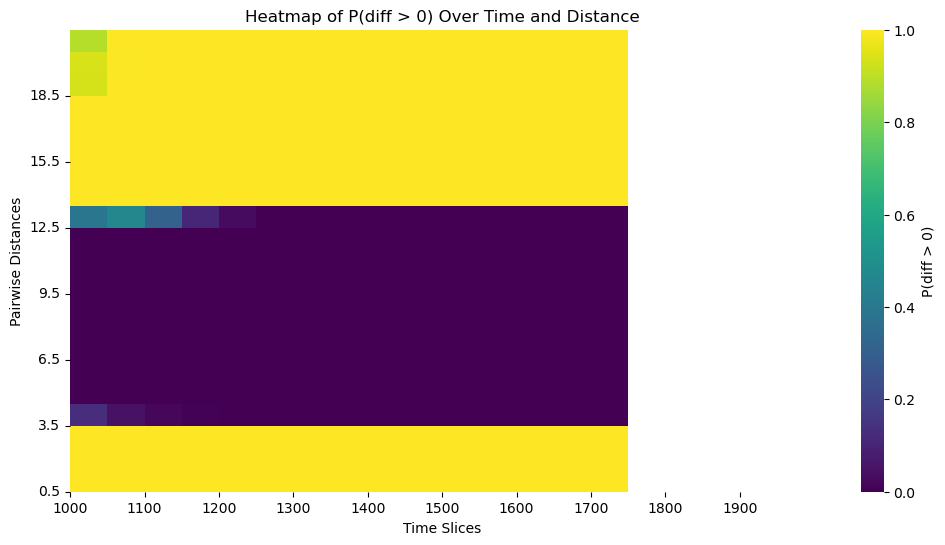

In [18]:
# Plot the heatmap of probabilities
pdiff_heatmap(p_diff_array, time_slices, support)

#### Explanation of the Code

1. Calculate P-Values (p_diff Function):
        - The p_diff function compares the observed clustering statistic to the CSR baseline for that statistic.
        - It calculates the p-values for the difference in density for each distance and time slice, indicating the probability that the observed pattern is different from CSR in a particular direction indicated by a parameter, `condition` that defaults to 'greater'.

2. Visualize P-Values (pdiff_heatmap Function):
        - The pdiff_heatmap function plots a heatmap of the p-values, with time slices on the x-axis and distances on the y-axis.
        - The color gradient represents the p-values, with warmer colors indicating higher p-values and cooler colors indicating lower p-values.

#### Interpretation of the Heatmap

Since we are looking at the difference between the observed pairwise distance distribution and a comparable CSR baseline,

1. High p-values:
        - Statistically significant clustering and/or point-distance structure at the indicated distance(s) and time(s) within the STV.
        - In the heatmap, these significant regions are indicated by warmer colours.
2. Low p-values:
        - Regions of the pairwise distance distribution (distance(s) and time(s)) that do not differ significantly from CSR within the STV.
        - In the heatmap, these non-significant regions are indicated by cooler colours.

### Other ChronoCluster Clustering Statistics
Using the same overall pipeline described above, the `ChronoCluster` package provides support for clustering analyses involving three other fundamental cluster statistics:

1. Ripley's K Function:
        - Purpose: Measures the number of points within a given distance of each point, adjusted for the overall density of points.
        - Function: temporal_cluster
        - Parameters: calc_K=True

2. Ripley's L Function:
        - Purpose: A linear transformation of Ripley's K function that stabilizes the variance under CSR.
        - Function: temporal_cluster
        - Parameters: calc_L=True

3. Pair Correlation Function (Ripley's G Function):
        - Purpose: Measures the density of points at a specific distance from a given point, providing insight into the spatial structure at different scales.
        - Function: temporal_cluster
        - Parameters: calc_G=True

#### Example Code for Ripley's K, L, and G Functions

Below is the example code for calculating Ripley's K, L, and G functions over time using the ChronoCluster package. This code is for reference and demonstrates how to set up the calculations, but we won't compute anything in this slide:

```python
# Define distances for Ripley's K function
distances = np.linspace(np.finfo(float).eps, max_distance, num=40)

# Calculate K, L, and G functions over time
k_results, l_results, g_results = clustering.temporal_cluster(simulations, 
                                                              distances, 
                                                              time_slices, 
                                                              calc_K=True, 
                                                              calc_L=True,
                                                              calc_G=True)

# Visualize the K function results with a heatmap
clustering_heatmap(k_results, distances, time_slices)
```

#### Explanation

1. Define Distances:
        - We define a range of distances over which to calculate the clustering statistics, ensuring that the distances cover the relevant scales of spatial interaction.

2. Calculate Clustering Statistics:
        - The temporal_cluster function is used to calculate Ripley's K, L, and G functions for each time slice and distance.
        - The parameters calc_K=True, calc_L=True, and calc_G=True indicate that all three statistics should be computed.

3. Visualize Results:
        - The results of the K function are visualized using a heatmap, similar to the approach taken for pairwise distances.
        - The clustering_heatmap function can be used to plot the results for L and G functions as well, providing insights into the clustering patterns over time and distance.